### Задание 1 - по тетрадке sem01_autograd.

1. Добавить Bias и посчитать для них градиенты.
2. Сравнить градиенты с тем, как считает PyTorch AutoGrad.

In [199]:
import numpy as np
import torch

In [200]:
batch_size = 64
input_size = 3
hidden_size = 2
output_size = 1
dtype = torch.float
device = torch.device('cpu')

In [203]:
# Create random input and output data
x = torch.randn(batch_size, input_size, device=device, dtype=dtype)
y = torch.randn(batch_size, output_size, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(input_size, hidden_size, device=device, dtype=dtype)
b1 = torch.randn(hidden_size, device=device, dtype=dtype)
w2 = torch.randn(hidden_size, output_size, device=device, dtype=dtype)
b2 = torch.randn(output_size, device=device, dtype=dtype)

# клонируем веса для AutoGrad (теперь указываем requires_grad=True)
w1_auto = w1.clone().detach().requires_grad_(True)
b1_auto = b1.clone().detach().requires_grad_(True)
w2_auto = w2.clone().detach().requires_grad_(True)
b2_auto = b2.clone().detach().requires_grad_(True)

learning_rate = 1e-6

In [ ]:
# первый цикл: вычисляем градиенты вручную
for t in range(500):
    # Forward pass: compute predicted y
    h_1 = x.mm(w1) + b1 
    h_relu = h_1.clamp(min=0) # ReLU
    out = h_relu.mm(w2) + b2 

    # Compute and print loss
    loss = (out - y).pow(2).sum().item()

    # ручное вычисление градиентов
    # dL/dout = 2 * (out - y)
    dloss_out = 2 * (out - y) 

    # градиенты для второго слоя
    # dL/dw2 = dL/dout * dout/dw2 = dL/dout * h_relu
    grad_w2 = h_relu.t().mm(dloss_out) 
    # dL/db2 = dL/dout * dout/db2 = dL/dout * 1, просуммированный по батчу
    grad_b2 = dloss_out.sum(dim=0) 

    # градиенты для первого слоя
    # dL/dh_relu = dL/dout * dout/dh_relu = dL/dout * w2
    grad_hrelu = dloss_out.mm(w2.t())  
    grad_hrelu[h_1 < 0] = 0 
    # dL/dw1 = dL/dh_relu * x
    grad_w1 = x.t().mm(grad_hrelu) 
    # dL/db1 = dL/dh_relu, сумма по батчу
    grad_b1 = grad_hrelu.sum(dim=0) 

    # обновление параметров
    w1 -= learning_rate * grad_w1
    b1 -= learning_rate * grad_b1
    w2 -= learning_rate * grad_w2
    b2 -= learning_rate * grad_b2

    if t % 100 == 99:
        print(f'Loss on iteration {t} = {loss}')
        print(f'grad_w1:{grad_w1}')
        print(f'grad_b1:{grad_b1}')
        print(f'grad_w2:{grad_w2}')
        print(f'grad_b2:{grad_b2}\n\n')


Loss on iteration 99 = 440.3583068847656
grad_w1:tensor([[-164.8078,  -20.0398],
        [ 184.9179,    6.4030],
        [  89.4661,   11.4157]])
grad_b1:tensor([201.2069,  16.4591])
grad_w2:tensor([[770.6304],
        [ 50.3117]])
grad_b2:tensor([187.1369])


Loss on iteration 199 = 374.002685546875
grad_w1:tensor([[-138.5314,  -17.4548],
        [ 158.4461,    5.7077],
        [  75.6277,   10.0953]])
grad_b1:tensor([171.0275,  14.4811])
grad_w2:tensor([[693.3124],
        [ 44.6760]])
grad_b2:tensor([169.6123])


Loss on iteration 299 = 320.8179931640625
grad_w1:tensor([[-117.0320,  -15.2836],
        [ 136.6395,    5.1223],
        [  64.2518,    8.9822]])
grad_b1:tensor([146.2735,  12.8178])
grad_w2:tensor([[626.9471],
        [ 39.7960]])
grad_b2:tensor([154.2293])


Loss on iteration 399 = 277.7212219238281
grad_w1:tensor([[-99.2862, -13.4420],
        [118.5043,   4.6245],
        [ 54.8207,   8.0348]])
grad_b1:tensor([125.7773,  11.4055])
grad_w2:tensor([[569.3818],
        [ 

In [205]:
# второй цикл: автоматический расчет градиентов
for t in range(500):
    # Forward pass: compute predicted y
    h_1_auto = x.mm(w1_auto) + b1_auto
    h_relu_auto = h_1_auto.clamp(min=0)
    out_auto = h_relu_auto.mm(w2_auto) + b2_auto

    # Compute and print loss
    loss_auto = (out_auto - y).pow(2).sum()

    # автоматическое вычисление градиентов с AutoGrad
    loss_auto.backward()
    
    if t % 100 == 99:
        print(f'Loss on iteration {t} = {loss_auto.item()}')
        print(f'grad_w1:{w1_auto.grad}')
        print(f'grad_b1:{b1_auto.grad}')
        print(f'grad_w2:{w2_auto.grad}')
        print(f'grad_b2:{b2_auto.grad}\n\n')

    # обновление параметров
    with torch.no_grad():
        w1_auto -= learning_rate * w1_auto.grad
        b1_auto -= learning_rate * b1_auto.grad
        w2_auto -= learning_rate * w2_auto.grad
        b2_auto -= learning_rate * b2_auto.grad

    # обнуление градиентов
    w1_auto.grad.zero_()
    b1_auto.grad.zero_()
    w2_auto.grad.zero_()
    b2_auto.grad.zero_()

Loss on iteration 99 = 440.3583068847656
grad_w1:tensor([[-164.8078,  -20.0398],
        [ 184.9179,    6.4030],
        [  89.4661,   11.4157]])
grad_b1:tensor([201.2069,  16.4591])
grad_w2:tensor([[770.6304],
        [ 50.3117]])
grad_b2:tensor([187.1369])


Loss on iteration 199 = 374.002685546875
grad_w1:tensor([[-138.5314,  -17.4548],
        [ 158.4461,    5.7077],
        [  75.6277,   10.0953]])
grad_b1:tensor([171.0275,  14.4811])
grad_w2:tensor([[693.3124],
        [ 44.6760]])
grad_b2:tensor([169.6123])


Loss on iteration 299 = 320.8179931640625
grad_w1:tensor([[-117.0320,  -15.2836],
        [ 136.6395,    5.1223],
        [  64.2518,    8.9822]])
grad_b1:tensor([146.2735,  12.8178])
grad_w2:tensor([[626.9471],
        [ 39.7960]])
grad_b2:tensor([154.2293])


Loss on iteration 399 = 277.7212219238281
grad_w1:tensor([[-99.2862, -13.4420],
        [118.5043,   4.6245],
        [ 54.8207,   8.0348]])
grad_b1:tensor([125.7773,  11.4055])
grad_w2:tensor([[569.3818],
        [ 

градиенты совпадают

### Задание 2. 

Ну что ж, пришло время построить свою первую нейронную сеть. У нас будет искуственная задачка, и мы посмотрим на её примере, как работают различные алгоритмы машинного обучения.

In [341]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [342]:
df = pd.read_csv('data.csv',index_col=0)

In [343]:
df.head(10)

x1        x2  y
0 -4.626272 -6.658988  0
1 -7.789640  0.262519  0
2 -8.739678  1.537758  0
3 -2.546441 -7.705224  0
4 -2.751506 -7.940187  0
5  0.303440  5.969639  0
6 -5.920224  1.339210  1
7 -7.555594  0.733846  1
8  5.995393 -4.607815  0
9  1.465613  4.338939  1

Как и в любой задаче машинного обучения, для начала надо визуализировать данные. 
Не зря же нашу нейронную сеть мы так долго учим?


<Axes: xlabel='x1', ylabel='x2'>

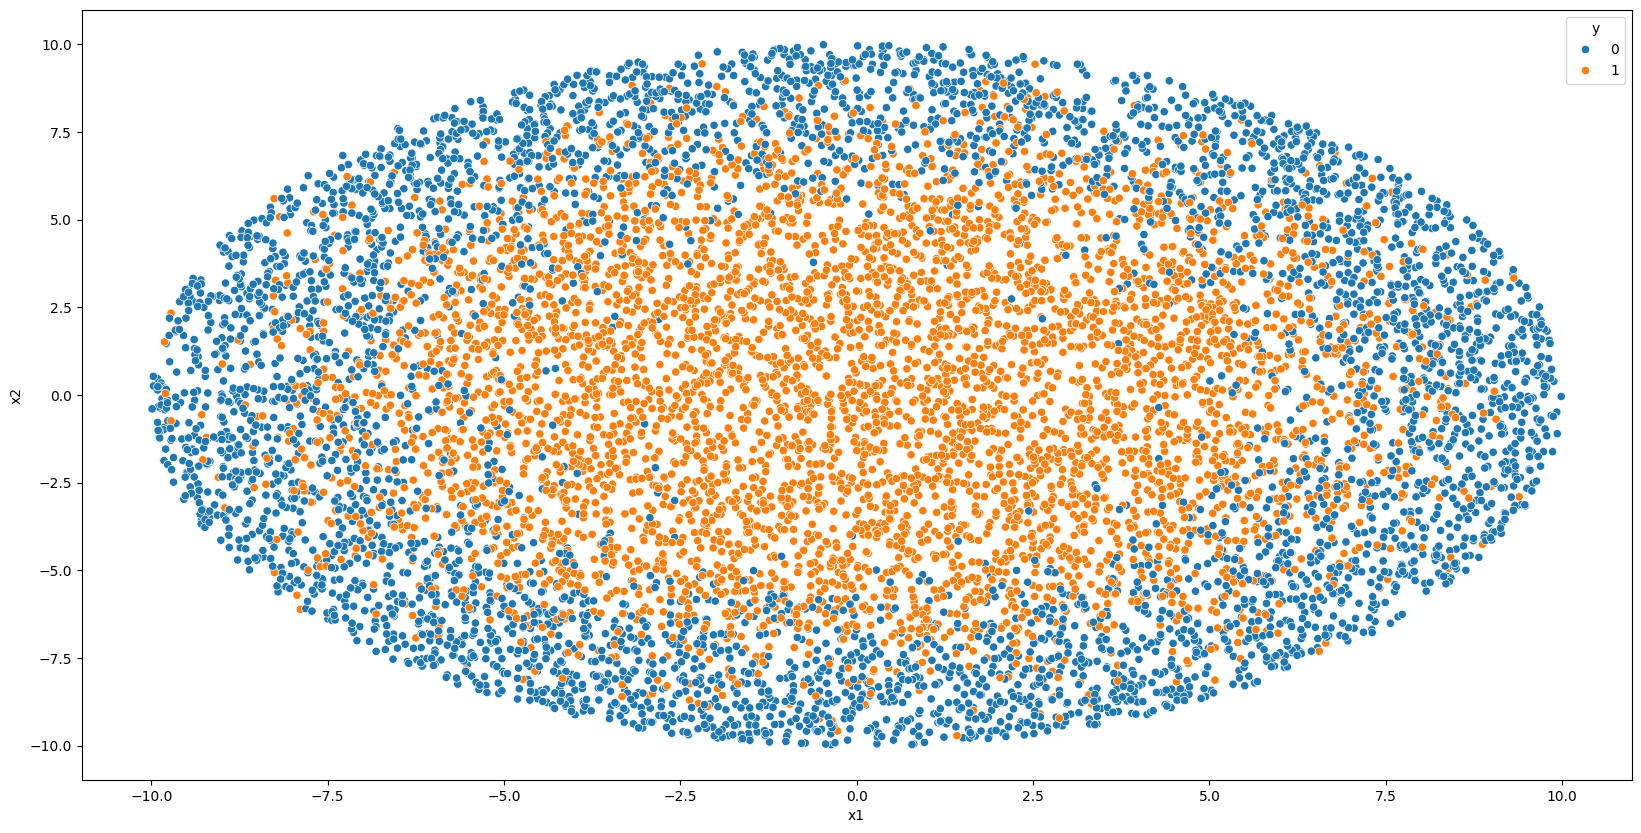

In [344]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="x1", y="x2", hue="y", data=df)

После просмотра данных встает несколько вопросов:
 * 1) Можем ли мы построить идеальную модель ? (условная метрика точность)
 * 2) Что ещё мы хотим знать о выборке?
 * 3) Какие алгоритмы машинного обучения мы можем эффективно здесь использовать?

1. Классы частично пересекаются, поэтому построить идеальную модель вряд ли получится
2. Есть ли пропущенные значения, сбалансированы ли классы
3. k-nearest neighbors, деревья решений и ансамбли (Random Forest, Gradient Boosting)

In [345]:
df.isnull().sum()

x1    0
x2    0
y     0
dtype: int64

In [346]:
df['y'].value_counts()

1    5097
0    4903
Name: y, dtype: int64

После описательного анализа приступим к построению моделей. Для начала посмотрим, что нам даст Логистическая регрессия. 

In [347]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

# разобьем выборку на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(df[['x1','x2']], df['y'], test_size=0.33, random_state=42)

Точность нашей модели 0.5963636363636363


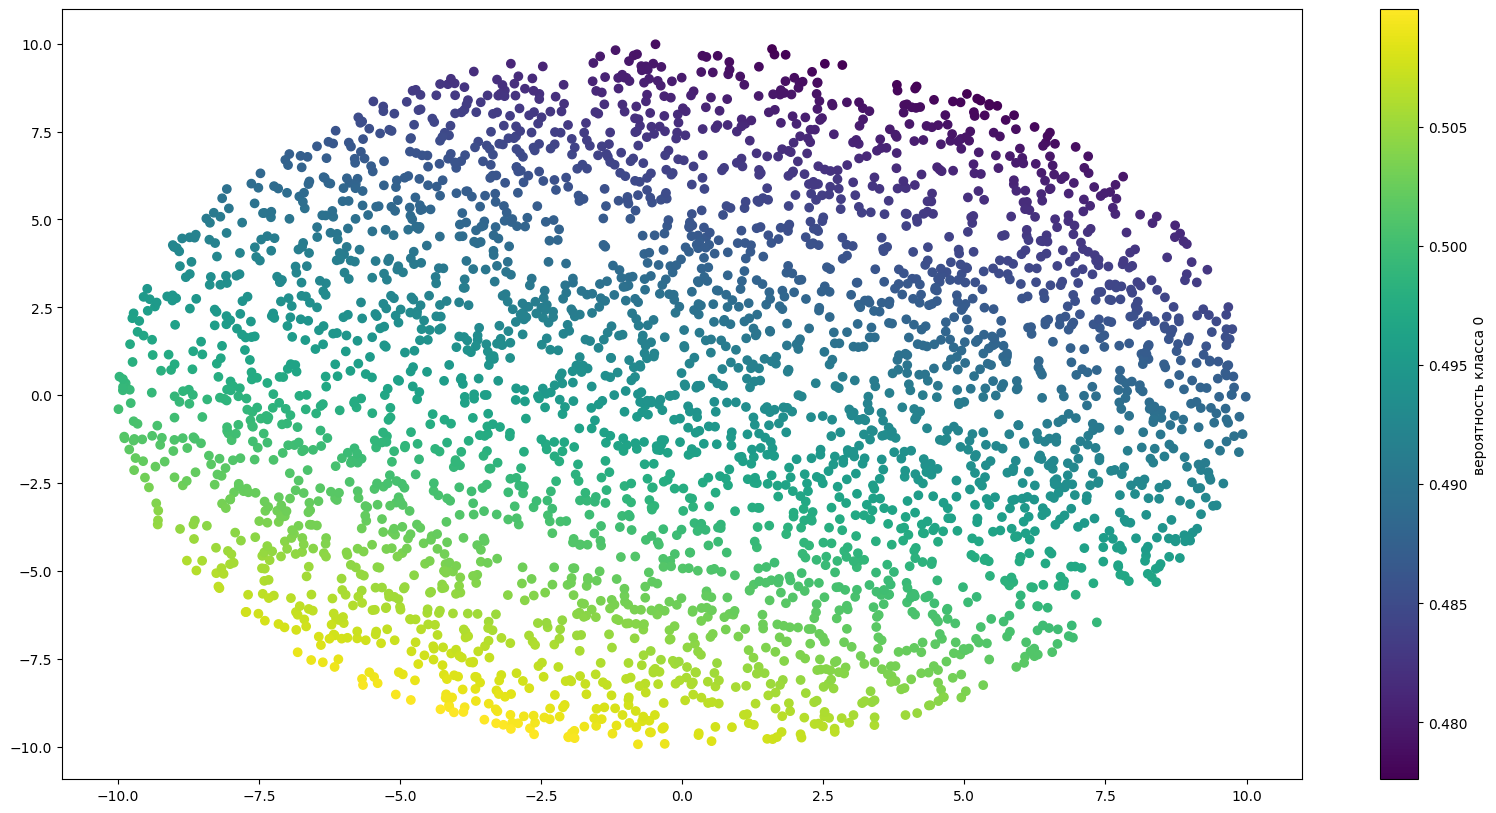

In [348]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

predict_logit = logistic_model.predict(X_test)
predict_log_proba = logistic_model.predict_proba(X_test)

print(f'Точность нашей модели {accuracy_score(predict_logit, y_test)}')

# Заодно завизуализируем полученные результаты
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_log_proba[:, 0])
plt.colorbar(label='вероятность класса 0')
plt.show()

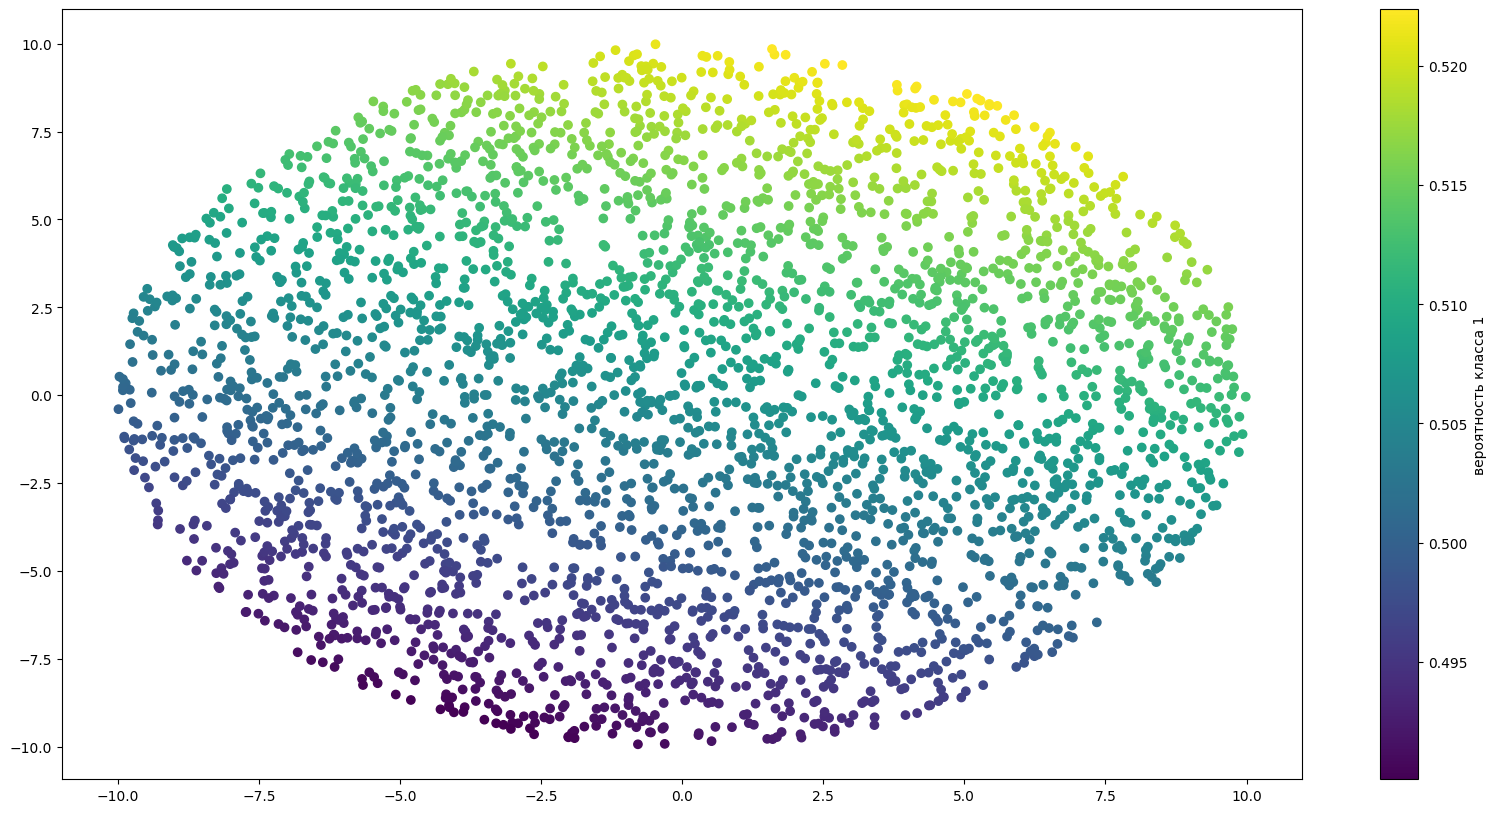

In [349]:
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_log_proba[:, 1])
plt.colorbar(label='вероятность класса 1')
plt.show()

Вообще машинное обучение не только про алгоритмы (нейронные сети не исключение),
 а скорее про обработку данных. Что нам надо добавить, чтобы наш алгоритм отработал без проблем?

Точность нашей модели 0.8409090909090909


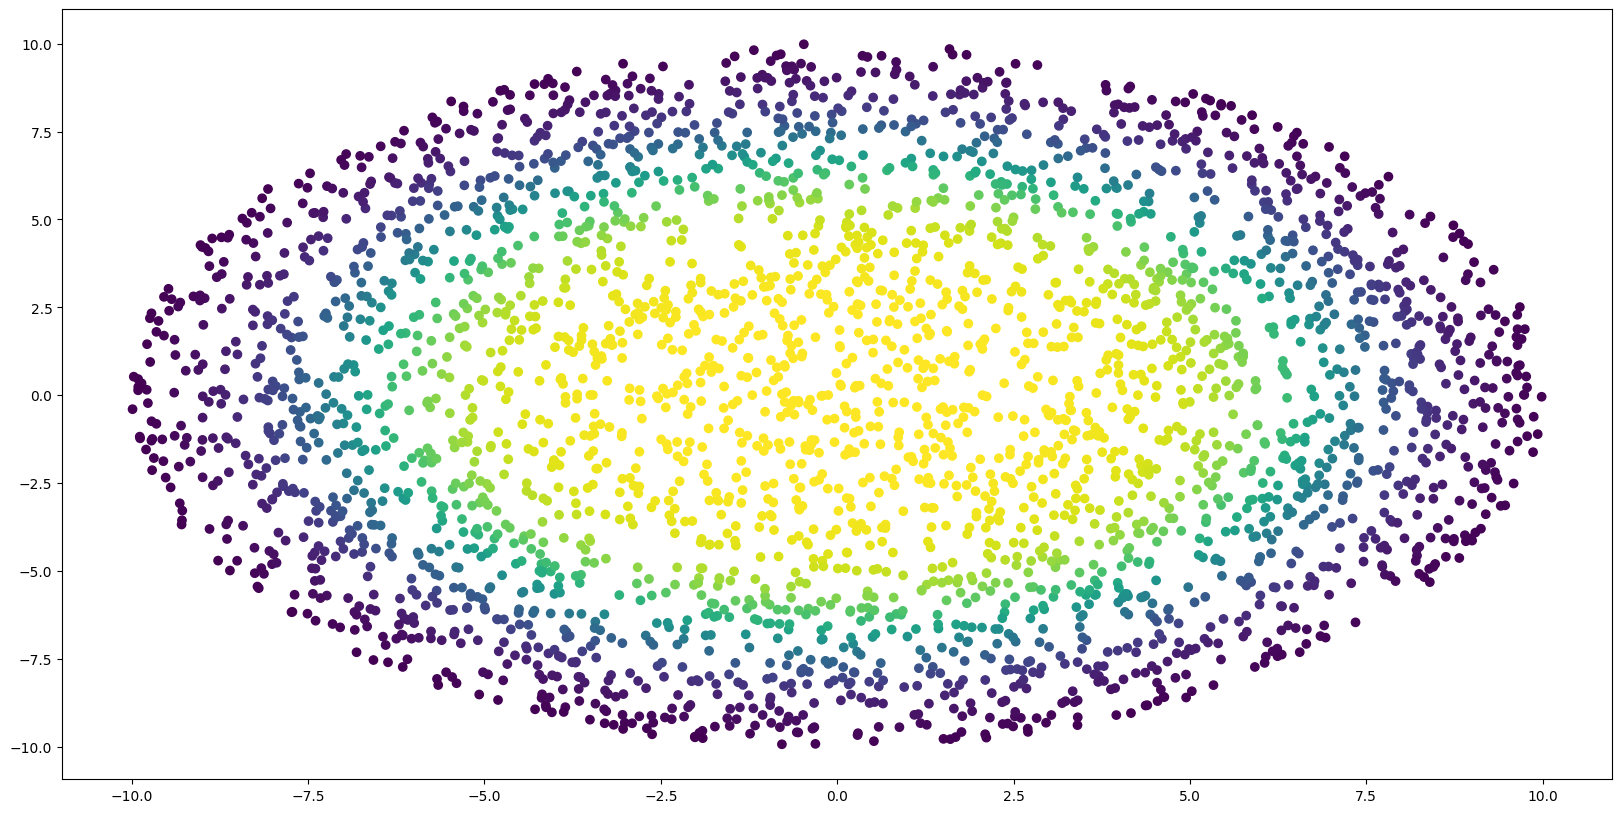

In [ ]:
# Повторяем наш код, только с новыми фичами - смотрим на магию
df_new = df.copy()

#########################################

df_new['new_feature_1'] = (df_new['x1'] ** 2 + df_new['x2'] ** 2) ** 0.5 # расстояние каждой точки от начала координат 
# данные расположены по кругу, и эта фича помогает лучше учитывать эту структуру  

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new[['x1', 'x2', 'new_feature_1']],
                                                                    df_new['y'], test_size=0.33, random_state=42)

logistic_model = LogisticRegression()
logistic_model.fit(X_train_new, y_train_new)

predict_logit = logistic_model.predict(X_test_new)
predict_log_proba = logistic_model.predict_proba(X_test_new)

#########################################

print(f'Точность нашей модели {accuracy_score(predict_logit,y_test_new)}')

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_log_proba[:, 1])
plt.show()

точность значительно повысилась, когда мы добавили новый признак

Переходим к следующему классу алгоритмов - деревья решений. Какая особенность есть у деревьев? Какой параметр надо зафикисировать, чтобы эта особенность не испортила обучение? 

1. Деревья решений склонны к переобучению
2. Нужно ограничить глубину дерева (max_depth)

Точность нашей модели 0.8093939393939394


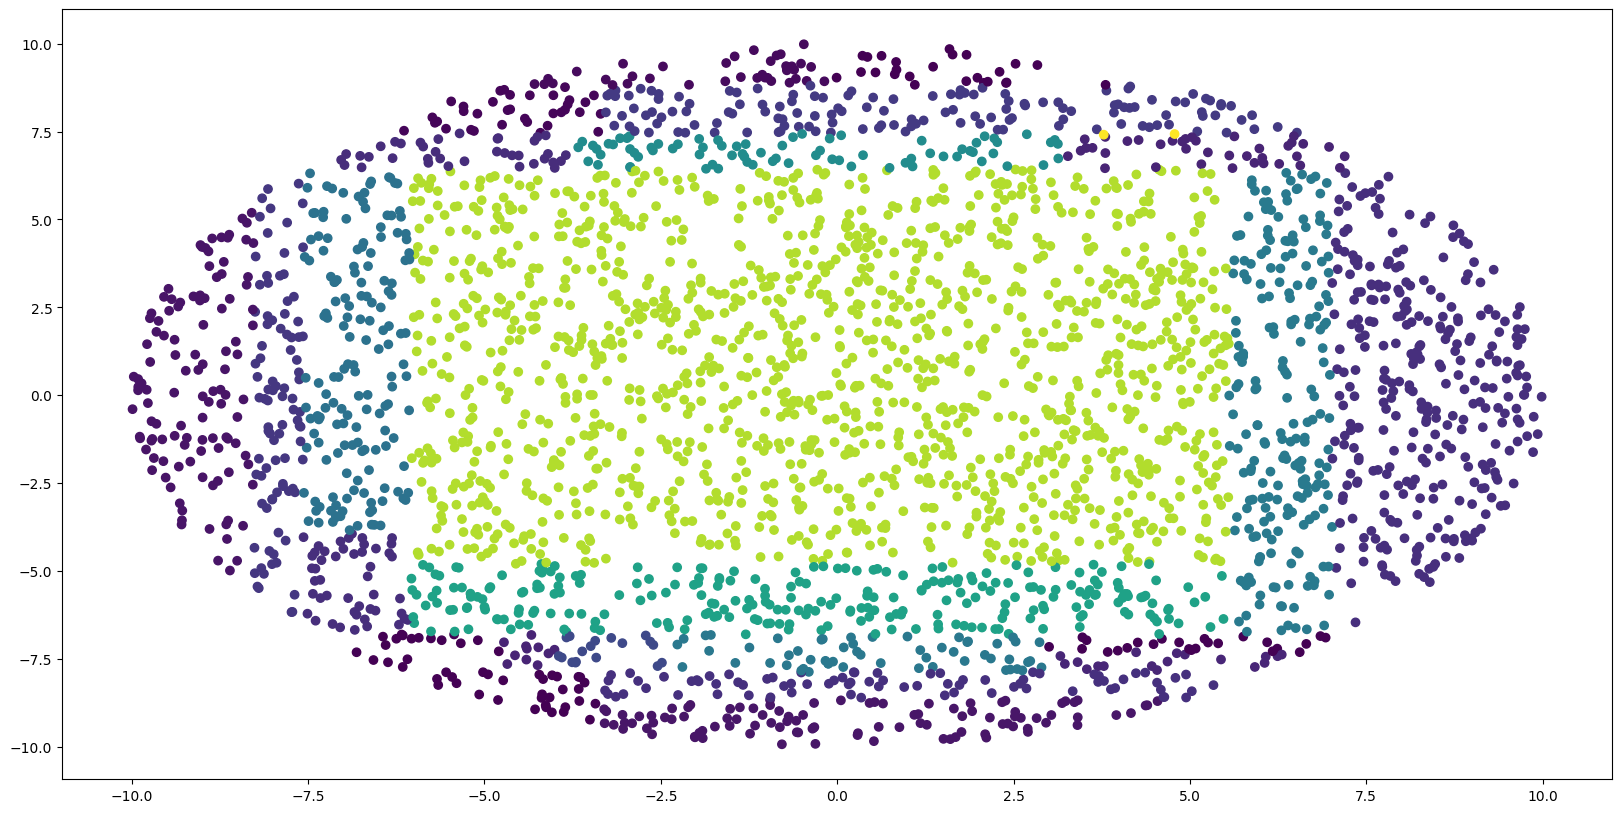

In [351]:
from sklearn.tree import DecisionTreeClassifier

#########################################
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

predict_tree = tree_model.predict(X_test)
print(f'Точность нашей модели {accuracy_score(predict_tree, y_test)}')

predict_tree_proba = tree_model.predict_proba(X_test)
#########################################

plt.figure(figsize=(20,10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_tree_proba[:, 1])
plt.show()

Поможет ли в данном случае ансамблирование? Когда в целом ансамбль дает хорошие результаты?

Ансамблирование может помочь, хотя в простых задачах иногда достаточно добавить подходящие фичи.  

Бэггинг уменьшает разброс (variance), усредняя предсказания базовых моделей, обученных на разных выборках из исходных данных. Он хорошо работает, когда базовые модели достаточно точны, но допускают разные ошибки.  
В бустинге модели обучаются последовательно, каждая последующая фокусируется на ошибках предыдущих. Это уменьшает смещение (bias) модели.  
Стекинг объединяет разные модели, чтобы учитывать их сильные стороны

Точность нашей модели 0.8254545454545454


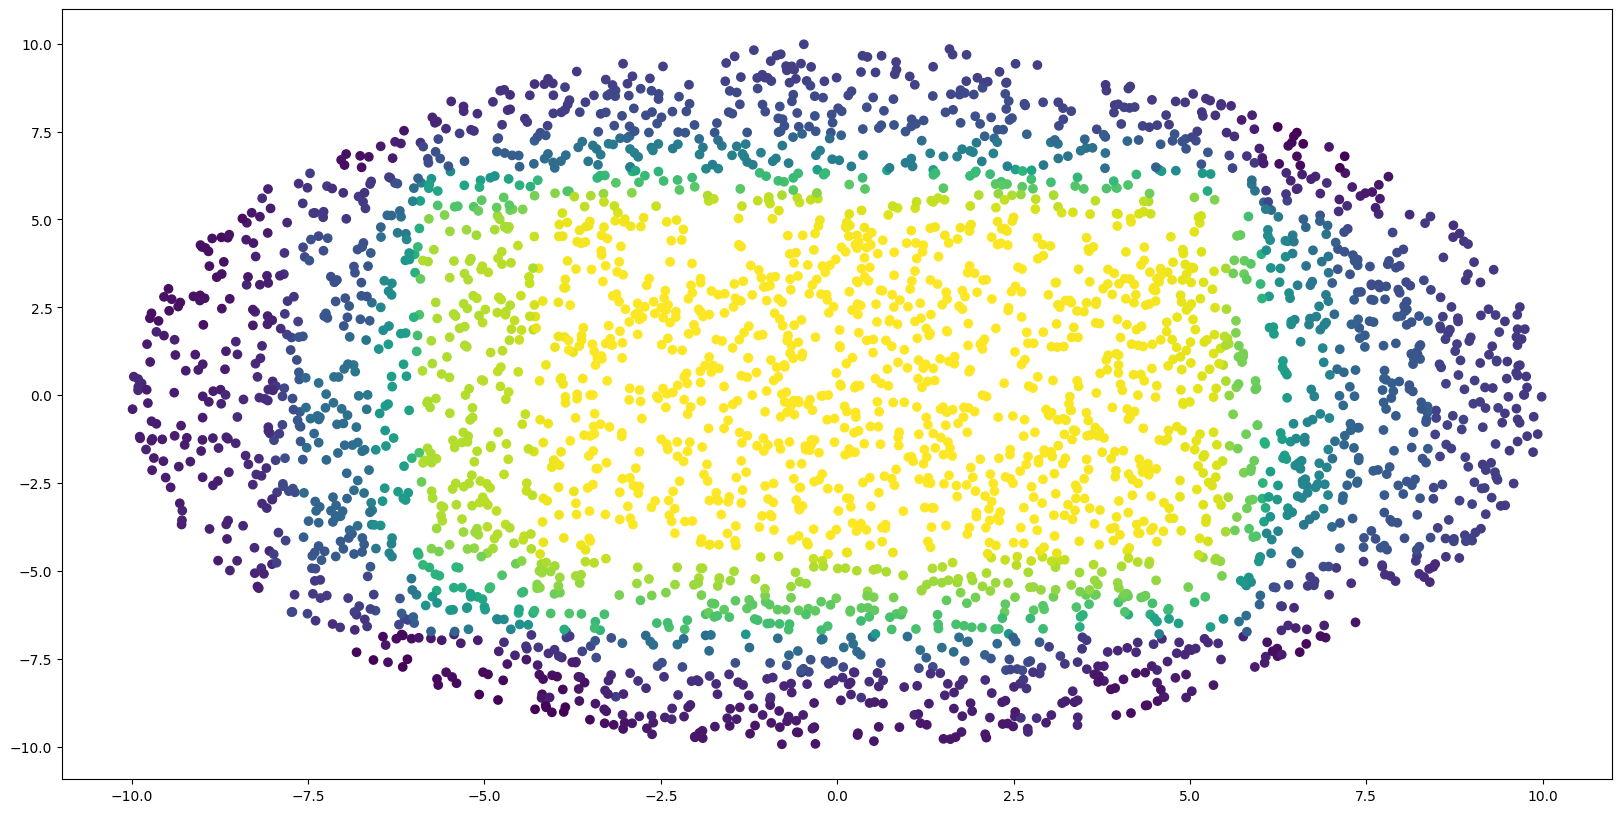

In [352]:
from sklearn.ensemble import RandomForestClassifier

#########################################

forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42) 
forest.fit(X_train, y_train)

predict_forest = forest.predict(X_test)
print(f'Точность нашей модели {accuracy_score(predict_forest, y_test)}')

predict_forest_proba = forest.predict_proba(X_test)

#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_forest_proba[:, 1])
plt.show()

ну и наконец мы добрались до нейронок - пора собрать нашу нейроночку под эту задачу.

Соберем простенькую нейронку - нам хватит 2х слоев по 5 нейронов в каждом. 

In [364]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import torch.utils.data as data_utils
from torchmetrics import Accuracy

In [365]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

# разобьем выборку на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(df[['x1','x2']], df['y'], test_size=0.33, random_state=42)

In [366]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=64,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=64,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy()) 

In [367]:
INPUT_SIZE = 2
HIDDEN_SIZE = 5
OUTPUT_SIZE = 1
LEARNING_RATE = 1e-3
EPOCHS = 100

In [368]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) 
        return x

In [369]:
model = MyModel()

In [370]:
criterion = nn.BCELoss()
accuracy = Accuracy(task='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [371]:
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train():
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # Reset gradients

            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label.unsqueeze(1).float())
            loss.backward()
            acc = accuracy(output, label.unsqueeze(1).int()).item()

            # Update weights with gradients
            optimizer.step()
            optimizer.zero_grad()

            running_loss.append(loss.item())
            running_acc.append(acc)

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print(f'EPOCH {epoch}: train_loss: {train_loss_values[-1]:.4f}, train_accuracy: {train_accuracy_values[-1]:.4f}')


        # Run validation
        running_loss = []
        running_acc = []
        for features, label in test_loader:
            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label.unsqueeze(1).float())
            acc = accuracy(output, label.unsqueeze(1).int()).item()

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print(f'EPOCH {epoch}: valid_loss: {valid_loss_values[-1]:.4f}, valid_accuracy: {valid_accuracy[-1]:.4f}')
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

In [372]:
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train()

EPOCH 0: train_loss: 0.7426, train_accuracy: 0.4929
EPOCH 0: valid_loss: 0.7290, valid_accuracy: 0.4829
EPOCH 20: train_loss: 0.4082, train_accuracy: 0.8304
EPOCH 20: valid_loss: 0.4094, valid_accuracy: 0.8322
EPOCH 40: train_loss: 0.3682, train_accuracy: 0.8377
EPOCH 40: valid_loss: 0.3747, valid_accuracy: 0.8379
EPOCH 60: train_loss: 0.3637, train_accuracy: 0.8391
EPOCH 60: valid_loss: 0.3694, valid_accuracy: 0.8417
EPOCH 80: train_loss: 0.3630, train_accuracy: 0.8385
EPOCH 80: valid_loss: 0.3680, valid_accuracy: 0.8423


In [373]:
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.to_numpy().astype(np.float32)))

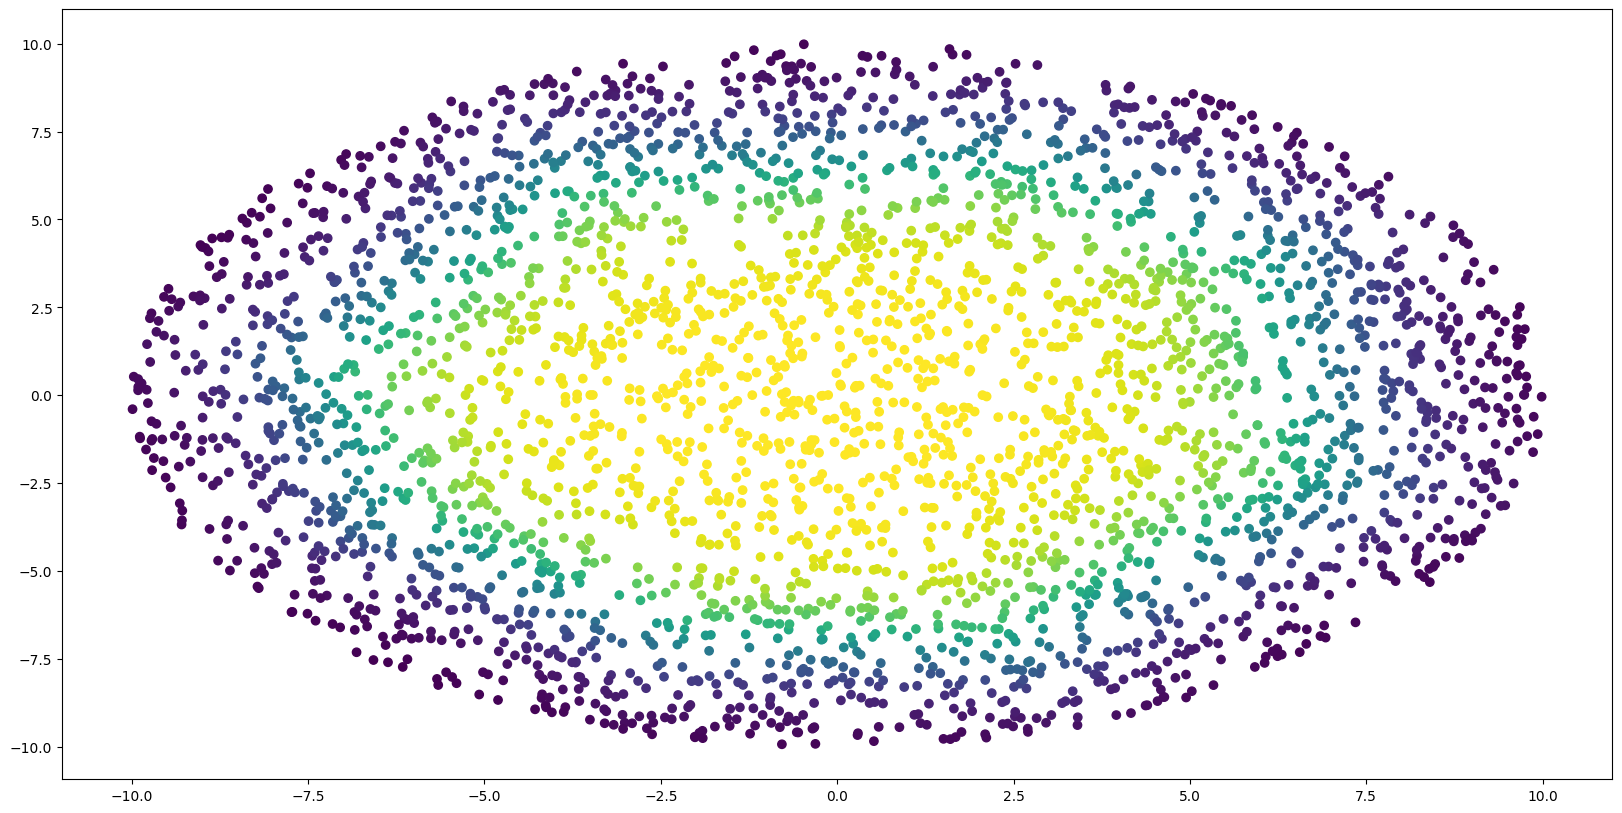

In [374]:
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=test_scores)
plt.show()

простая нейронная сеть показывает неплохой результат, сравнимый с другими моделями, но идеальная модель здесь, как уже было сказано выше, вряд ли возможна